In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
plt.style.use('dark_background')

In [55]:
# Creating some data
x_train = np.array([ *np.random.multivariate_normal((1,0), 1e-2*np.eye(2), 80),  *np.random.multivariate_normal((0,1), 1e-2*np.eye(2), 80)])
y_train = np.array([*-np.ones(80), *np.ones(80)])
x_test = np.array([ *np.random.multivariate_normal((1,0), 1e-2*np.eye(2), 20),  *np.random.multivariate_normal((0,1), 1e-2*np.eye(2), 20)])
y_test = np.array([*-np.ones(20), *np.ones(20)])

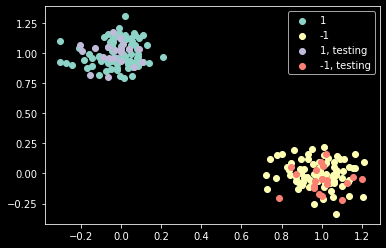

In [56]:
fig, ax = plt.subplots()
ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

ax.scatter( x_test[ y_test == 1, 0], x_test[y_test == 1, 1], label = "1, testing")
ax.scatter( x_test[ y_test == -1, 0], x_test[y_test == -1, 1], label = "-1, testing")

ax.legend()
plt.show()

In [57]:
accuracy = lambda predicted, label: np.mean((predicted==label))

find_y = lambda x,w,b : (-b-w[0]*x)/w[1]

class svm:
    @classmethod
    def __init__(self, trade_off: int = 10):
        self.w = None
        self.b = None
        self.trade_off = trade_off
        self.learning_rate = None
        self.best_w = None
        self.best_b = None
        self.opt_cost = 1e9
        

    @staticmethod
    def shuffle(train: np.ndarray, labels: np.ndarray):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = np.random.permutation(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels
    
    @classmethod
    def iterate_minibatches(self, train : np.ndarray, labels: np.ndarray, batch_size : int):
        """
        Gives minibatches
        """
        train, labels = self.shuffle(train,labels)
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]

    @classmethod
    def cost(self, train, labels):
        return self.w @ self.w + np.maximum( 0 , 1 - labels @ (train @ self.w + self.b))

    
    @classmethod
    def fit_util(self, train: np.ndarray, labels: np.ndarray):
        """
        Utility function for fit
        """
        indices = (labels * (train @ self.w + self.b )) < 1.
        grad_b = -np.sum(labels[indices])
        grad_w = 2 * self.w  - self.trade_off * (labels[indices] @ train[indices])
        self.b -=  self.learning_rate * grad_b
        self.w -= self.learning_rate * grad_w / self.trade_off
        if self.opt_cost > self.cost(train, labels):
            self.best_b = self.b
            self.best_w = self.w
            self.opt_cost = self.cost(train, labels)




    @classmethod
    def animate():
        pass

    @classmethod
    def fit(self, train, labels, learning_rate : int = 0.1 ,epochs : int = 10, batch_size = 10):
        """
        Trains the weights
        """
        self.learning_rate = learning_rate
        s = train.shape[1]
        self.w = np.random.normal(np.zeros(s, dtype = float))
        self.b = 0
        
    
        
            
        for epoch in range(epochs):
            train, labels = self.shuffle(train, labels)
            for x,y in self.iterate_minibatches(train, labels, batch_size):
                self.fit_util(x, y)
            fig, ax = plt.subplots()
            ax.set_xlim(-0.5,1.5)
            ax.set_ylim(-0.5,1.5)
            ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
            ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

            x_coords = np.array([-0.6, 1.6])
            dist = 1/clf.w[1]
            ax.plot( x_coords, find_y(x_coords, clf.w, clf.b), label = "separating_line" )

            ax.fill_between(x_coords, find_y(x_coords, clf.w, clf.b) - dist, find_y(x_coords, clf.w, clf.b)+dist, label = "slab", edgecolor = None, alpha=0.4, color='white')

            ax.legend(loc='upper right')
            plt.savefig(f'fig/{epoch}.png')
            plt.close()
            clear_output()

        self.w = self.best_w
        self.b = self.best_b
                

    @classmethod
    def predict(self, test):
        """
        returns the predicted label
        """
        logits = test @ self.w + self.b
        return np.sign(logits)



In [60]:
clf = svm(100)
clf.fit(x_train, y_train, epochs = 1000, batch_size = 4, learning_rate = 0.01)
y_pred = clf.predict(x_test)
print("The accuracy of our model is {}".format(accuracy(y_pred, y_test)))

The accuracy of our model is 1.0


In [61]:
import imageio
with imageio.get_writer('mygif.gif', mode='I',) as writer:
    for filename in range(1000):
        image = imageio.imread(f'fig/{filename}.png')
        writer.append_data(image)